## Define model blocks

In [2]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [3]:
import torch.nn as nn
import torch.nn.functional as F

In [4]:
def crop(enc_ftrs, x):
    _, _, H, W = x.shape
    enc_ftrs   = transforms.CenterCrop([H, W])(enc_ftrs)
    return enc_ftrs

In [5]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3)
        self.bn2 = nn.BatchNorm2d(out_ch)
    
    def forward(self, x):
        return self.relu(self.conv2(self.relu(self.conv1(x))))

In [6]:
class Encoder(nn.Module):
    def __init__(self, chs=(1,64,128,256,512,1024)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)
    
    def forward(self, x):
        enc_fmap = []
        for block in self.enc_blocks:
            x = block(x)
            enc_fmap.append(x)
            x = self.pool(x)
        return enc_fmap


In [7]:
class Decoder(nn.Module):
    def __init__(self, chs=(1024, 512, 256, 128, 64)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 

    def forward(self, x, encoder_features):
        dec_fmap = []
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            enc_ftrs = crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
            dec_fmap.append(x)
        return dec_fmap

## Define model

In [8]:
class UNet2D(nn.Module):
    def __init__(self, enc_chs=(1,64,128,256,512), dec_chs=(512, 256, 128, 64), 
                 num_class=1, retain_dim=False, out_sz=(256,256), return_fmap=False):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim
        self.Fmap = return_fmap
        self.out_sz = out_sz
        
    def forward(self, x):
        enc_fmaps = self.encoder(x)
        dec_fmaps      = self.decoder(enc_fmaps[::-1][0], enc_fmaps[::-1][1:])
        out      = self.head(dec_fmaps[-1])

        if self.retain_dim:
            out = F.interpolate(out, self.out_sz)
        if self.Fmap:
            return enc_fmaps+dec_fmaps+[out]
        return out

## Define dataset

In [9]:
pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
import os
import pandas as pd
import pydicom
from torch import from_numpy
from torch.utils.data import Dataset
import numpy as np
from PIL import Image

In [11]:
dict_values = {"foie":63, "rein_droit":126, "rein_gauche":189, "rate":256}

def processMaskMultiClasses(maskArray, dict_Values):
    mask = []
    for key in dict_Values:
        val = dict_Values[key]
        maskSlice = maskArray.astype("int")
        maskSlice[maskSlice !=int(val)]=0
        maskSlice[maskSlice !=0]=1
        mask.append(maskSlice)
    return mask


def processMask2Classes(maskArray, dict_Values):
    val = dict_Values["foie"]
    maskArray[maskArray !=int(val)]=0
    maskArray[maskArray !=0]=1
    return maskArray

In [12]:
def getDicom2D(MRPath, dtype = "int"):
    if dtype == "int":
      im = pydicom.dcmread(MRPath).pixel_array.astype("int16")
    else:
      im = pydicom.dcmread(MRPath).pixel_array.astype("float32")
    return im

def getMask2D(MRPath, mode = "bi", dtype = "int"):
    im = np.asarray(Image.open(MRPath)).astype("int16")
    if mode == "multi":
        return processMaskMultiClasses(im,dict_values)
    return processMask2Classes(im, dict_values)

In [13]:
import matplotlib.pyplot as plt

In [14]:
class Dataset(Dataset):
    'characterizes a dataset for pytorch'
    def __init__(self, df, transform=None, train = True):
        self.df = df
        self.transform = transform
        self.train = train

    def __len__(self):
        'denotes the total number of samples'
        return(len(self.df.index))

    def __getitem__(self, index):
        'Generates one sample of data'
        #select sample
        path_mr = os.path.join(self.df["root"].iloc[index], self.df["localImPath"].iloc[index])
        X = getDicom2D(path_mr)
        if self.transform:
            X = self.transform(X)

        if self.train:
            path_mask = os.path.join(self.df["root"].iloc[index], self.df["localMaskPath"].iloc[index])
            y = getMask2D(path_mask)
            if self.transform:
                y = self.transform(y)
            return X,y
        return X

    def get_mean_std(self):
      #Get the mean and standard variation of the dataframe
      list_X = []
      for i in range(len(self.df)):
        path_mr = os.path.join(self.df["root"].iloc[i], self.df["localImPath"].iloc[i])
        X = getDicom2D(path_mr, dtype="float")
        print("before",np.max(X), np.min(X))
        if self.transform:
            X = self.transform(X)
        print("after",torch.max(X), torch.min(X))
        list_X.append(X)
      return torch.mean(torch.cat(list_X, dim = 0), dim = 0), torch.std(torch.cat(list_X, dim = 0), dim = 0)


## Define train function

In [15]:
import torchvision
import torchvision.transforms as transforms
from torch.optim import Adam
import torch

In [16]:
def saveModel(model, epoch, loss, savePath,teacher = True):
    if teacher:
      path = os.path.join(savePath, f"epoch{epoch}_loss{loss}_model_teacher.pth")
      torch.save(model.state_dict(), path)
    else:
      path = os.path.join(savePath, f"epoch{epoch}_loss{loss}_model_student.pth")
      torch.save(model.state_dict(), path)


def train(model, criterion, optimizer, N_epoch, 
          trainloader, testloader, transform,
          savePath, device, teacher = True, train_mean = None, train_std = None, scheduler = None):
    
    best_val_loss = 10**10
    train_losses = []
    val_losses = []
    
    for epoch in range(N_epoch):  # loop over the dataset multiple times

        print(f"epoch {epoch} is starting")
        
        running_loss = 0.0
        running_val_loss = 0.0 
        
        for i, data in enumerate(trainloader, 1):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            #Normalize dataset if mean and std are given
            if train_mean is not None and train_std is not None:
              for i in range(len(inputs)):
                inputs[i] = (inputs[i] - train_mean[None,:,:])/train_std[None,:,:]

            inputs, labels = inputs.float(), labels.float()
            inputs = inputs.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()
    
            # forward + backward + optimize
            outputs = model(inputs)
            s = outputs.shape[-1]
            labels = transforms.Resize(s, interpolation = transforms.InterpolationMode.NEAREST)(labels)
            labels =  labels.to(device)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

            #================================================================================================7
            #Data augmentation
            print("Fliping")

            #Flip images and begin again whole processes
            inputs = transforms.RandomVerticalFlip(1)(inputs)
            labels = transforms.RandomVerticalFlip(1)(labels)
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()
    
            # forward + backward + optimize
            outputs = model(inputs)
            s = outputs.shape[-1]
            labels = transforms.Resize(s, interpolation = transforms.InterpolationMode.NEAREST)(labels)
            labels =  labels.to(device)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            #Update scheduler
            if scheduler is not None:
              scheduler.step()

            # print statistics
            running_loss += loss.item()

            #Validation part using DiceBCE loss
            with torch.no_grad():
                model.eval() 
                for data in testloader:  
                   inputs, labels = data
                   if train_mean is not None and train_std is not None:
                    for i in range(len(inputs)):
                      inputs[i] = (inputs[i] - train_mean[None,:,:])/train_std[None,:,:]
                   inputs, labels = inputs.float(), labels.float()
                   inputs, labels = inputs.to(device), labels.to(device)
                   predicted_outputs = model(inputs)
                   s = outputs.shape[-1]
                   labels = transforms.Resize(s, interpolation = transforms.InterpolationMode.NEAREST)(labels)
                   labels =  labels.to(device)
                   val_loss = criterion(predicted_outputs, labels)
          
                   running_val_loss += val_loss.item()

        # Save the model if the validation loss is the lowest
        if running_val_loss < best_val_loss:
            saveModel(model, epoch, running_val_loss, savePath,teacher) 
            best_val_loss = running_val_loss
        
        train_losses.append(running_loss/(len(trainset)))
        val_losses.append(running_val_loss/(len(testset)))
         
        # Print the statistics of the epoch 
        print('Completed training batch', epoch, 'Training Loss is: %.4f' %running_loss, 'Validation Loss is: %.4f' %running_val_loss)
    return train_losses, val_losses

## Losses and others

In [18]:
class DiceBCELoss(nn.Module):
    #Classic loss for segmentation task: it is a combination of the Dice loss and cross entropy loss
    
    def __init__(self, alpha=0.5, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()
        self.alpha = alpha
        self.weight = weight
        self.size_average = size_average

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)
        
        #flatten label and prediction tensors
        inputs = inputs.reshape(-1)
        targets = targets.reshape(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = self.alpha*BCE + self.alpha*dice_loss
        
        return Dice_BCE

In [19]:
class Features_loss(nn.Module):
    
    #Importance maps distillation loss

    def __init__(self, alpha=0.5, weight=None, size_average=True):
        super(Features_loss,self).__init__()
        self.alpha = alpha
        self.weight = weight
        self.size_average = size_average

    def forward(self, inputs, targets, attention_function, smooth=1):
        total_loss = 0
        input, target = get_attention_maps(inputs, targets, attention_function)

        for index, (input1, target1) in enumerate(zip(input, target)):
          norm_input = input1/torch.norm(input1,2)
          norm_target = target1/torch.norm(target1,2)
          distill_loss = torch.norm(norm_input - norm_target,2)
          total_loss += distill_loss

        
        return total_loss/len(inputs)

In [20]:
from torch.nn import KLDivLoss
#We will use Kullback-Leibler divergence loss as a loss on the prediction probability distribution output

In [21]:
#Metric we will use for evaluation part
#It is just the Dice score
class Dice(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(Dice, self).__init__()
        self.weight = weight
        self.size_average = size_average

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)
        
        #flatten label and prediction tensors
        inputs = inputs.reshape(-1)
        targets = targets.reshape(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return dice_loss

## Launch Trainig

In [22]:
root = r"/content/gdrive/MyDrive/ProCom1/ProCom/Data"
traincsv = pd.read_csv(os.path.join(root, "train2D.csv"))

In [23]:
traincsv["root"] = root

In [24]:
traincsv["localImPath"] = traincsv["localImPath"].apply(lambda x: x.replace("\\", "/"))
traincsv["localMaskPath"] = traincsv["localMaskPath"].apply(lambda x: x.replace("\\", "/"))

In [25]:
traincsv.head(2)

,root,MR_number,slice_number,localImPath,localMaskPath
0,/content/gdrive/MyDrive/ProCom1/ProCom/Data,1,IMG-0002-00001,CHAOS_Train_Sets/Train_Sets/MR/1/T2SPIR/DICOM_...,CHAOS_Train_Sets/Train_Sets/MR/1/T2SPIR/Ground...
1,/content/gdrive/MyDrive/ProCom1/ProCom/Data,1,IMG-0002-00002,CHAOS_Train_Sets/Train_Sets/MR/1/T2SPIR/DICOM_...,CHAOS_Train_Sets/Train_Sets/MR/1/T2SPIR/Ground...


In [26]:
weights_path = r"/content/gdrive/MyDrive/ProCom1/ProCom/Data/Model_save"

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

batch_size = 16    

savePath = root + "/Model_save"
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.CenterCrop(size=256)])


train80 = traincsv.sample(frac = 0.8, random_state=5)
test20 = traincsv.drop(train80.index)
trainset = Dataset(train80, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True)

testset = Dataset(test20, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False)

cuda


In [ ]:
model = UNet2D()
model.to(device)
criterion = DiceBCELoss()
optimizer = Adam(model.parameters(), lr=0.000925, weight_decay=0.0001)
steps = 4
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, steps)

N_epoch = 20

loss_train, loss_val = train(model, criterion, optimizer, 25, 
          trainloader, testloader, transform,
          savePath, device, teacher = True, scheduler = scheduler)
print('Finished Training')


## Functions used for evaluation

In [29]:
def plotCurves(train, test):
  #Plot train and test curves
  x = np.arange(1,21,1)
  plt.plot(x,train)
  plt.plot(x,test)
  plt.legend(["train", "test"])
  plt.show()
  

In [30]:
def eval(model, testloader, transform, device, criterion):
    #Get the mean Dice score
    model.eval()
    train_losses = []
    val_losses = []
    for i, data in enumerate(testloader, 1):
        # get the inputs; data is a list of [inputs, labels]
        print(i)
        inputs, labels = data
        inputs, labels = inputs.float(), labels.float()

        outputs = model(inputs)
        s = outputs.shape[-1]
        labels = transforms.Resize(s, interpolation = transforms.InterpolationMode.NEAREST)(labels)
        loss = criterion(outputs, labels)
        val_losses.append(loss)
        torch.cuda.empty_cache()

    return sum(val_losses)/len(val_losses)

In [31]:
def showEval(inputs, outputs, labels):
    #Print visual representation of our results
    #Need to use processOutput() function before calling this
    fig, axs = plt.subplots(1, 2, figsize=(16, 9), constrained_layout=True)
    
    ax1, ax2 = axs
    
    ax1.imshow(torch.squeeze(inputs[0].cpu()), cmap='Greys_r')
    ax1.imshow(torch.squeeze(outputs[0].detach()), alpha=0.5)
    ax2.imshow(torch.squeeze(inputs[0].cpu()), cmap='Greys_r')
    ax2.imshow(torch.squeeze(labels[0].cpu()), alpha=0.5)

In [32]:
from torch.nn.functional import sigmoid

In [33]:
def processOutput(model, testloader, transform, device, n):
    #Get and do a preprocessing on predictions results
    #We will consider the first image/result of the n-th batch
    #We need to do a preprocessing on labels and outputs in order to get a visualization
    #After calling this function, we can use showEval() function
    model.eval()
    for i, data in enumerate(testloader):
      if i ==n:
        inputs, labels = data
        inputs, labels = inputs.float(), labels.float()
        outputs = model(inputs)
        s = outputs.shape[-1]
        labels = transforms.Resize(s, interpolation = transforms.InterpolationMode.NEAREST)(labels)
        outputs = sigmoid(outputs)
        outputs[outputs<0.5]=0
        outputs[outputs>=0.5]=1
    return inputs, outputs, labels

## Train student model without knowledge distillation

In [ ]:
from torchsummary import summary

savePath = root + "/Model_save/Student_without_kd"
student1 =UNet2D(enc_chs=(1,32,64,128,256), dec_chs=(256,128, 64,32))
optimizer = Adam(student1.parameters(), lr=0.0001, weight_decay=0.0001)
steps = 4
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, steps)
student1.to(device)
print(summary(student1, (1, 256, 256)))
loss_train, loss_val = train(student1, criterion, optimizer, N_epoch, 
          trainloader, testloader, transform,
          savePath, device, teacher = False, scheduler = scheduler)
print('Finished Training')

In [ ]:
from torchsummary import summary

savePath = root + "/Model_save/Student_without_kd"
student2 =UNet2D(enc_chs=(1,32,64,128), dec_chs=(128, 64,32))
optimizer = Adam(student2.parameters(), lr=0.0001, weight_decay=0.0001)
steps = 4
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, steps)
student2.to(device)
print(summary(student2, (1, 256, 256)))
loss_train, loss_val = train(student2, criterion, optimizer, N_epoch, 
          trainloader, testloader, transform,
          savePath, device, teacher = False, scheduler = scheduler)
print('Finished Training')

In [ ]:
from torchsummary import summary

savePath = root + "/Model_save/Student_without_kd"
student3 =UNet2D(enc_chs=(1,32,64), dec_chs=(64,32))
optimizer = Adam(student3.parameters(), lr=0.0001, weight_decay=0.0001)
steps = 4
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, steps)
student3.to(device)
print(summary(student3, (1, 256, 256)))
loss_train, loss_val = train(student3, criterion, optimizer, N_epoch, 
          trainloader, testloader, transform,
          savePath, device, teacher = False, scheduler = scheduler)
print('Finished Training')

##Train distilled student model

In [ ]:
def mean_attention_function(output):
  #Input: feature map
  #Output: attention map

  #We will do a sum over the channel axis
  output = torch.sum(output**2, 1)
  return output

def get_attention_maps(Soutputs, Toutputs, attention_function):
  #Function that outputs all pairs of attention maps

  #First, get lists of attention maps from the feature maps
  Sattention_maps = []
  Tattention_maps = []
  for i in range(len(Soutputs)):
    Smap = attention_function(Soutputs[i])
    Sattention_maps.append(Smap)
  for i in range(len(Toutputs)):
    Tmap = attention_function(Toutputs[i])
    Tattention_maps.append(Tmap)

  #Then, get all attention maps shapes, in order to keep only the pairs that have same shape
  S_results = []
  T_results = []
  for i in range(len(Sattention_maps)):
    S_results.append(Sattention_maps[i].shape)
  for i in range(len(Tattention_maps)):
    T_results.append(Tattention_maps[i].shape)

  
  #Keep only the pairs of attention maps (teacher's and student's) that have the same shape
  list_shape = [len(S_results), len(T_results)]
  minimum = list_shape.index(max(list_shape))
  if minimum == 0: #means that S_results has less values
    #We should remove some of the teacher's attention maps
    for i in reversed(range(len(T_results))):
      if T_results[i] not in S_results:
        T_results.pop(i)
        Tattention_maps.pop(i)
    for i in reversed(range(len(S_results))):
      if S_results[i] not in T_results:
        S_results.pop(i)
        Sattention_maps.pop(i)
  else: #means that T_results has less values -> almost impossible because Tmodel is always heavier than Smodel
    #We should remove some of the student's attention maps
    for i in reversed(range(len(S_results))):
      if S_results[i] not in T_results:
        S_results.pop(i)
        Sattention_maps.pop(i)
    for i in reversed(range(len(T_results))):
      if T_results[i] not in S_results:
        T_results.pop(i)
        Tattention_maps.pop(i)
            
  return Sattention_maps, Tattention_maps

def saveModelDistilled(model, epoch, loss, savePath): 
    path = os.path.join(savePath, f"epoch{epoch}_loss{loss}_model_student_distilled.pth")
    torch.save(model.state_dict(), path) 


In [ ]:
from torch import softmax

def trainDistilled(teacher_model, student_model, followed_criterion, out_criterion, optimizer, N_epoch, 
          trainloader, testloader, transform,
          savePath, device, train_mean = None, train_std = None, scheduler = None):

    #Custom function to do the training of a student model, using knowledge distillation
    
    best_val_loss = 10**10
    train_losses = []
    val_losses = []
    for p in teacher_model.parameters(): #Check that the teacher is not learning, only the student should learn
      p.requires_grad_(False)
    for p in student_model.parameters():
      p.requires_grad_(True)
    
    for epoch in range(N_epoch):  # loop over the dataset multiple times

        print(f"epoch {epoch} is starting")
        
        running_loss = 0.0
        running_val_loss = 0.0 
        
        for i, data in enumerate(trainloader, 1):
            student_model.train()
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.float(), labels.float()
            inputs = inputs.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()
    
            # forward + backward + optimize
            Toutputs = teacher_model(inputs)
            Soutputs = student_model(inputs)
            s = Soutputs[-1].shape[-1]
            labels = transforms.Resize(s, interpolation = transforms.InterpolationMode.NEAREST)(labels)
            labels =  labels.to(device)

            #Loss function
            kl = KLDivLoss(reduction = "batchmean")
            softmax = nn.Softmax(dim=1)
            Toutputs[-1] = softmax(Toutputs[-1])
            Toutputs[-1] = transforms.Resize(s, interpolation = transforms.InterpolationMode.NEAREST)(Toutputs[-1])
            loss = out_criterion(Soutputs[-1], labels) + 0.9*followed_criterion(Soutputs, Toutputs, mean_attention_function) + 0.1*kl(softmax(Soutputs[-1]), Toutputs[-1])

            loss.backward(gradient = loss.grad)
            
            optimizer.step()

            # print statistics
            running_loss += loss.item()


            #Flipping =============================================================================================

            #Data augmentation

            #Flip images and begin again whole processes
            inputs = transforms.RandomVerticalFlip(1)(inputs)
            labels = transforms.RandomVerticalFlip(1)(labels)
            inputs, labels = inputs.to(device), labels.to(device)
            inputs, labels = inputs.float(), labels.float()
            inputs = inputs.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()
    
            # forward + backward + optimize
            Toutputs = teacher_model(inputs)
            Soutputs = student_model(inputs)
            s = Soutputs[-1].shape[-1]
            labels = transforms.Resize(s, interpolation = transforms.InterpolationMode.NEAREST)(labels)
            labels =  labels.to(device)

            #To do distillation knowledge, we need attention maps that have same dimensions
            Toutputs[-1] = softmax(Toutputs[-1])
            Toutputs[-1] = transforms.Resize(s, interpolation = transforms.InterpolationMode.NEAREST)(Toutputs[-1])
            loss = out_criterion(Soutputs[-1], labels) + 0.9*followed_criterion(Soutputs, Toutputs, mean_attention_function) + 0.1*kl(softmax(Soutputs[-1]), Toutputs[-1])

            loss.backward(gradient = loss.grad)
            
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            
            #Update scheduler
            if scheduler is not None:
              scheduler.step()

            #Validation part using DiceBCE loss
            with torch.no_grad():
                model.eval()
                for data in testloader:  
                   inputs, labels = data
                   inputs, labels = inputs.float(), labels.float()
                   inputs, labels = inputs.to(device), labels.to(device)
                   predicted_outputs = student_model(inputs)
                   s = predicted_outputs[-1].shape[-1]
                   labels = transforms.Resize(s, interpolation = transforms.InterpolationMode.NEAREST)(labels)
                   labels =  labels.to(device)
                   val_loss = out_criterion(predicted_outputs[-1], labels)
          
                   running_val_loss += val_loss.item()

        # Save the model if the validation loss is the lowest
        if running_val_loss < best_val_loss:
            saveModelDistilled(student_model, epoch, running_val_loss, savePath) 
            best_val_loss = running_val_loss
        
        train_losses.append(running_loss/(len(trainset)))
        val_losses.append(running_val_loss/(len(testset)))
         
        # Print the statistics of the epoch 
        print('Completed training batch', epoch, 'Training Loss is: %.4f' %running_loss, 'Validation Loss is: %.4f' %running_val_loss)
    return train_losses, val_losses

In [ ]:
from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
Tmodel = UNet2D(return_fmap=True)
Tmodel.load_state_dict(torch.load(weights_path +"/epoch22_loss40.193396396934986_model_teacher.pth"))
Tmodel = Tmodel.to(device)
Smodel1 = UNet2D(enc_chs=(1,32,64,128,256), dec_chs=(256,128, 64,32), return_fmap=True)
Smodel1 = Smodel1.to(device)
out_criterion = DiceBCELoss()
followed_criterion = Features_loss()
savePath = root + "/Model_save/Student_distilled"
print(summary(Smodel1, (1, 256, 256)))
optimizer = Adam(Smodel1.parameters(), lr=0.0001, weight_decay=0.0001)
steps = 4
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, steps)
train_loss, val_loss = trainDistilled(Tmodel, Smodel1, followed_criterion, out_criterion, optimizer, N_epoch, 
          trainloader, testloader, transform,
          savePath, device, scheduler = scheduler)

In [ ]:
from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
Tmodel = UNet2D(return_fmap=True)
Tmodel.load_state_dict(torch.load(weights_path +"/epoch22_loss40.193396396934986_model_teacher.pth"))
Tmodel = Tmodel.to(device)
Smodel2 = UNet2D(enc_chs=(1,32,64,128), dec_chs=(128, 64,32), return_fmap=True)
Smodel2 = Smodel2.to(device)
out_criterion = DiceBCELoss()
followed_criterion = Features_loss()
savePath = root + "/Model_save/Student_distilled"
print(summary(Smodel2, (1, 256, 256)))
optimizer = Adam(Smodel2.parameters(), lr=0.0001, weight_decay=0.0001)
steps = 4
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, steps)
train_loss, val_loss = trainDistilled(Tmodel, Smodel2, followed_criterion, out_criterion, optimizer, 25, 
          trainloader, testloader, transform,
          savePath, device, scheduler = scheduler)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
Tmodel = UNet2D(return_fmap=True)
Tmodel.load_state_dict(torch.load(weights_path +"/epoch22_loss40.193396396934986_model_teacher.pth"))
Tmodel = Tmodel.to(device)
Smodel3 = UNet2D(enc_chs=(1,32,64), dec_chs=( 64,32), return_fmap=True)
Smodel3 = Smodel3.to(device)
out_criterion = DiceBCELoss()
followed_criterion = Features_loss()
savePath = root + "/Model_save/Student_distilled"
print(summary(Smodel3, (1, 256, 256)))
optimizer = Adam(Smodel3.parameters(), lr=0.0001, weight_decay=0.0001)
steps = 4
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, steps)
train_loss, val_loss = trainDistilled(Tmodel, Smodel3, followed_criterion, out_criterion, optimizer, 25, 
          trainloader, testloader, transform,
          savePath, device, scheduler = scheduler)

##Evaluate teacher model

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet2D()
#Load teacher model
model.load_state_dict(torch.load(weights_path + "/epoch22_loss40.193396396934986_model_teacher.pth"))

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.CenterCrop(size=256)])

loss = eval(model, testloader, transform, device, Dice())

1


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


2
3
4
5
6
7
8


loss: tensor(0.7408, grad_fn=<DivBackward0>)


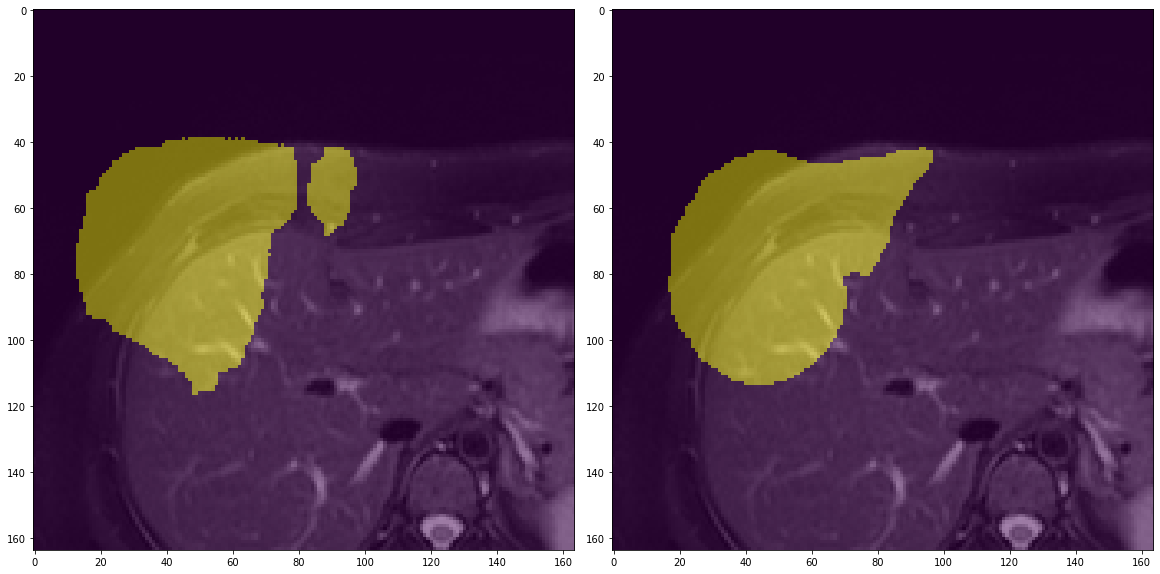

In [37]:
print("Dice score:",loss)
inputs, outputs, labels = processOutput(model, testloader, transform, device, 2)
showEval(inputs.cpu(), outputs.cpu(), labels.cpu())

##Evaluate student model without knowledge distillation

In [32]:
#Evaluate student model
savePath = root + "/Model_save/Student_without_kd"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
student1 =UNet2D(enc_chs=(1,32,64,128,256), dec_chs=(256,128, 64,32))
student1.load_state_dict(torch.load(savePath + "/epoch19_loss47.060441590845585_model_student.pth"))

loss = eval(student1, testloader, transform, device,Dice())

1


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


2
3
4
5
6
7
8


loss: tensor(0.6931, grad_fn=<DivBackward0>)


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


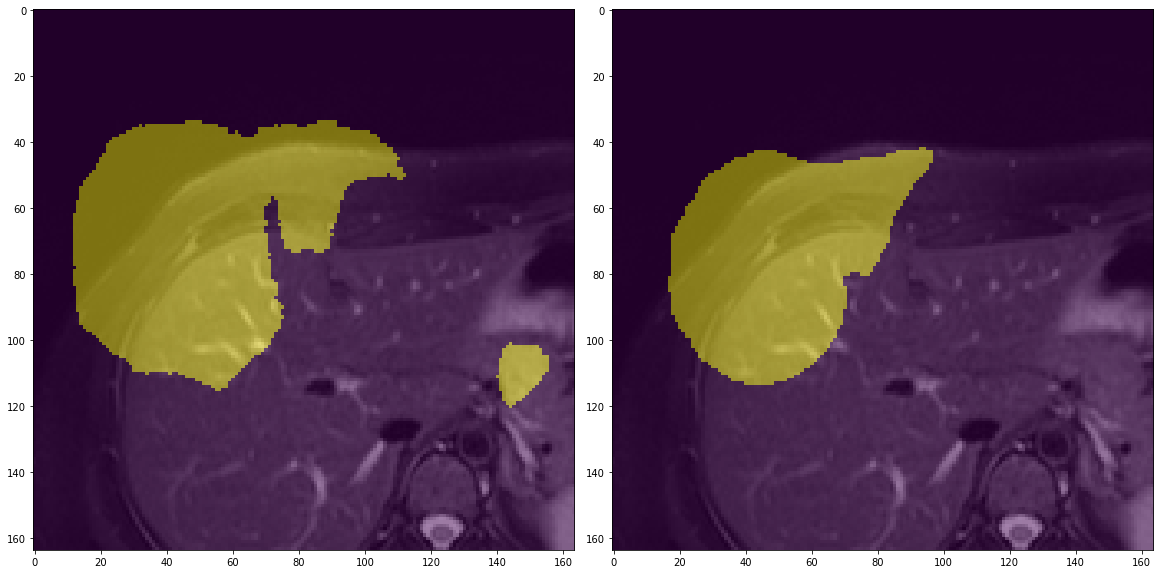

In [35]:
#Print some predictions
print("Dice score:",loss)
inputs, outputs, labels = processOutput(student1, testloader, transform, device, 2)
showEval(inputs.cpu(), outputs.cpu(), labels.cpu())

In [36]:
#Evaluate student model
savePath = root + "/Model_save/Student_without_kd"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
student2 =UNet2D(enc_chs=(1,32,64,128), dec_chs=(128, 64,32))
student2.load_state_dict(torch.load(savePath + "/epoch18_loss53.893035009503365_model_student.pth"))

loss = eval(student2, testloader, transform, device,Dice())

1


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


2
3
4
5
6
7
8


loss: tensor(0.5647, grad_fn=<DivBackward0>)


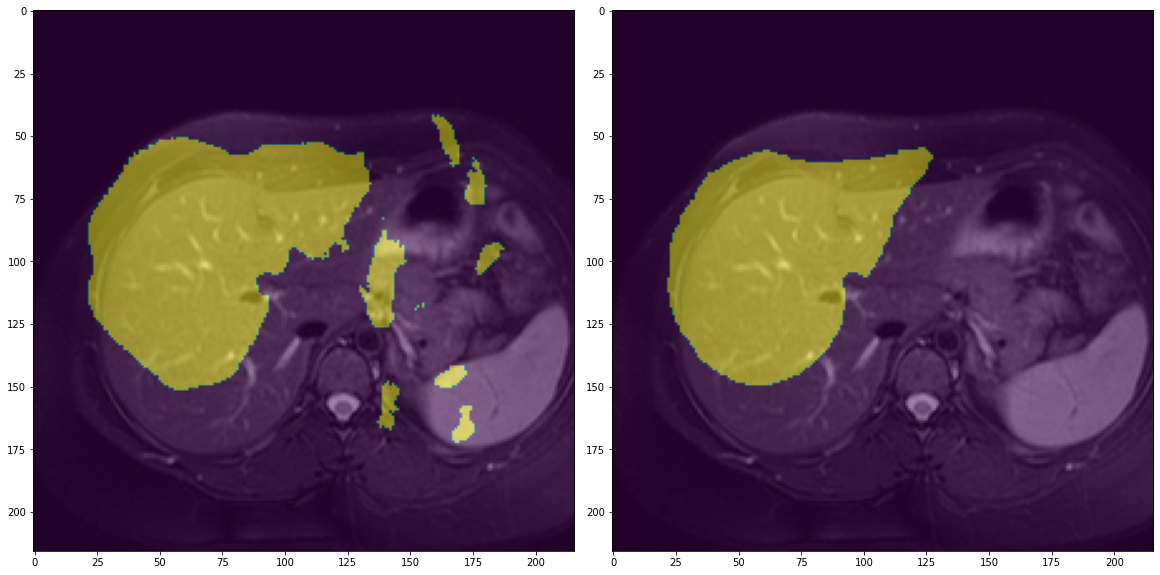

In [37]:
#Print some predictions
print("Dice score:",loss)
inputs, outputs, labels = processOutput(student2, testloader, transform, device, 2)
showEval(inputs.cpu(), outputs.cpu(), labels.cpu())

In [38]:
#Evaluate student model
savePath = root + "/Model_save/Student_without_kd"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
student3 =UNet2D(enc_chs=(1,32,64), dec_chs=(64,32))
student3.load_state_dict(torch.load(savePath + "/epoch19_loss95.85242435336113_model_student.pth"))

loss = eval(student3, testloader, transform, device,criterion)

1


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


2
3
4
5
6
7
8


loss: tensor(0.3767, grad_fn=<DivBackward0>)


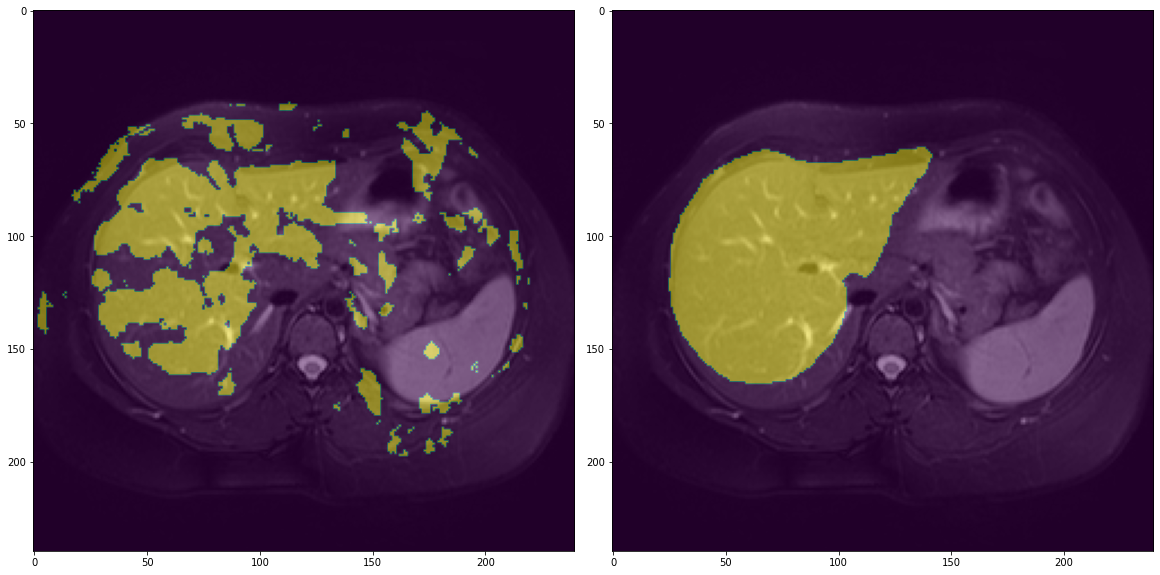

In [39]:
#Print some predictions
print("Dice score:",loss)
inputs, outputs, labels = processOutput(student3, testloader, transform, device, 2)
showEval(inputs.cpu(), outputs.cpu(), labels.cpu())

## Evaluate distilled student model

In [42]:
student_dis1 =UNet2D(enc_chs=(1,32,64,128,256), dec_chs=(256,128, 64,32))
savePath = root + "/Model_save/Student_distilled"
student_dis1.load_state_dict(torch.load(savePath + "/epoch18_loss44.02955214679241_model_student_distilled.pth"))
loss = eval(student_dis1, testloader, transform, device, Dice())

1


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


2
3
4
5
6
7
8


loss: tensor(0.7345, grad_fn=<DivBackward0>)


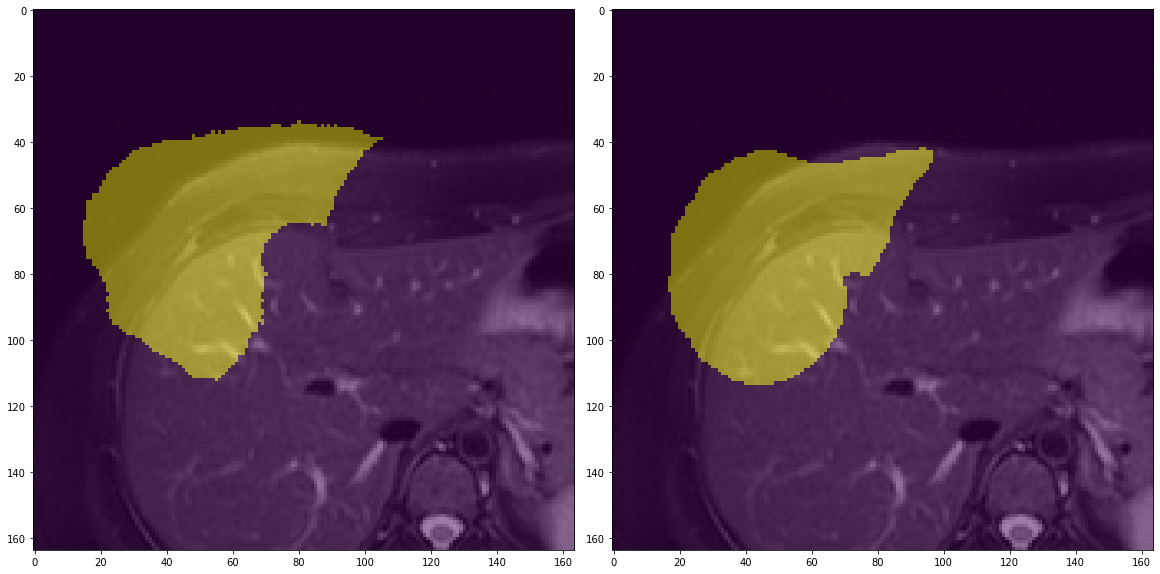

In [43]:
#Print some predictions
print("Dice score:",loss)
inputs, outputs, labels = processOutput(student_dis1, testloader, transform, device, 2)
showEval(inputs.cpu(), outputs.cpu(), labels.cpu())

In [45]:
student_dis2 =UNet2D(enc_chs=(1,32,64,128), dec_chs=(128, 64,32))
savePath = root + "/Model_save/Student_distilled"
student_dis2.load_state_dict(torch.load(savePath + "/epoch19_loss55.02849568426609_model_student_distilled.pth"))
loss = eval(student_dis2, testloader, transform, device, Dice())

1


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


2
3
4
5
6
7
8


loss: tensor(0.6487, grad_fn=<DivBackward0>)


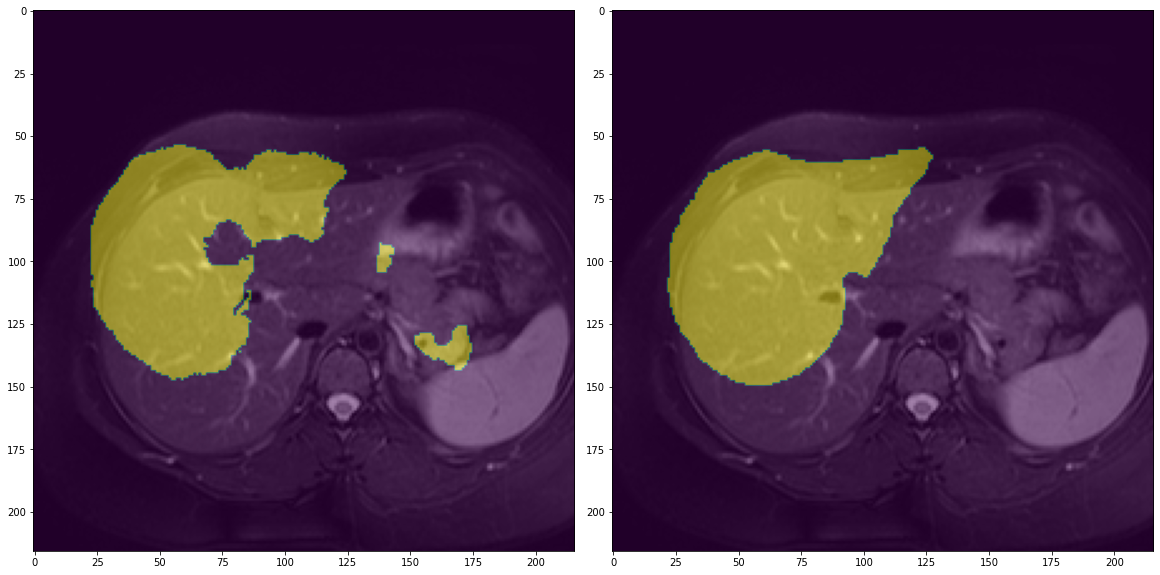

In [46]:
#Print some predictions
print("Dice score:",loss)
inputs, outputs, labels = processOutput(student_dis2, testloader, transform, device, 2)
showEval(inputs.cpu(), outputs.cpu(), labels.cpu())

In [49]:
student_dis3 =UNet2D(enc_chs=(1,32,64), dec_chs=(64,32))
savePath = root + "/Model_save/Student_distilled"
student_dis3.load_state_dict(torch.load(savePath + "/epoch19_loss83.85111406445503_model_student_distilled.pth"))
loss = eval(student_dis3, testloader, transform, device, Dice())

1


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


2
3
4
5
6
7
8


loss: tensor(0.4708, grad_fn=<DivBackward0>)


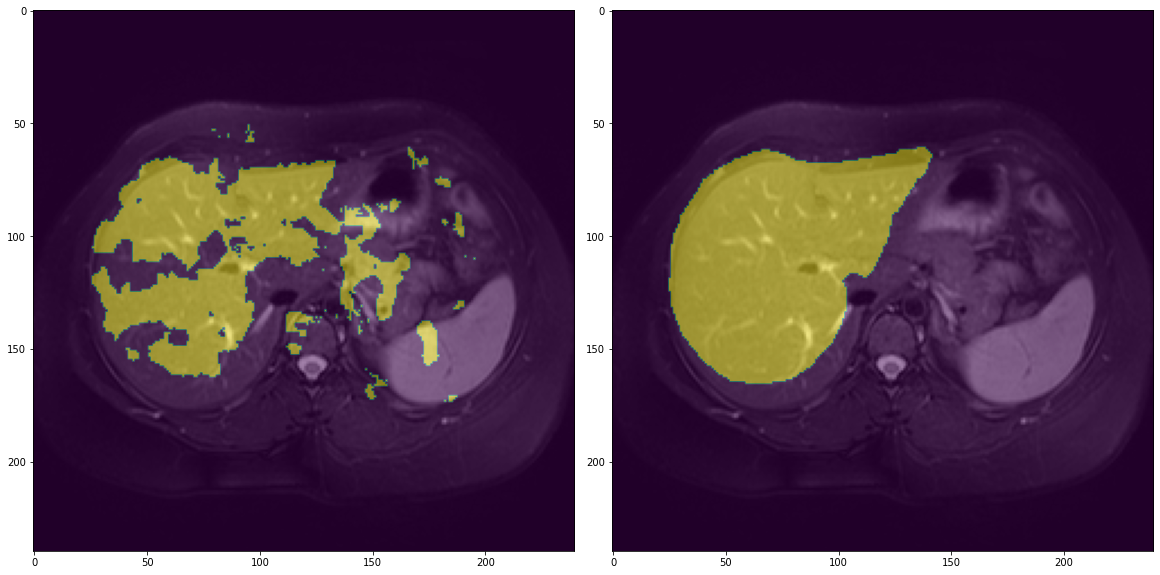

In [50]:
#Print some predictions
print("Dice score:",loss)
inputs, outputs, labels = processOutput(student_dis3, testloader, transform, device, 2)
showEval(inputs.cpu(), outputs.cpu(), labels.cpu())